In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

In [66]:
def plot_evolution(best_fit, title):
    plt.plot(best_fit) 
    plt.title(title)
    plt.ylabel('Fitness')
    plt.xlabel('Generation')    
    plt.show()

def plot_result_comparisson(results, label_list):
    for i in range(len(results)):
        plt.plot(list(range(len(results[i]))), results[i], label = label_list[i])  
    plt.legend()
    plt.title("Results comparisson")
    plt.show()
    
def plot_time_comparisson(time, label_list):
    plt.barh(label_list,time)
    for index, value in enumerate(time):
        plt.text(value, index,"%.2f" %  value)
    plt.title("Time comparisson (seconds)")
    plt.show()

# Rastrigin function
(https://en.wikipedia.org/wiki/Rastrigin_function)

In mathematical optimization, the Rastrigin function is a non-convex function used as a performance test problem for optimization algorithms due to a large amount of local minima. 

For our approach, the dimensions of the Rastrigin function will be 5, and A has fixed value of 10.

$ f(x) = A * d + sum(x_i^2 - A * cos(2 * pi * x_i)) $


PSO based of https://induraj2020.medium.com/implementing-particle-swarm-optimization-in-python-c59278bc5846

GA based of ChatGPT

# GA

Using a Genetic Algorithm approach with the values of X (5 dimensions) as individuals, and trying to minimize the Rastrigin function.

For this, the following parameters were fixed:
- Population size = 100
- Dimensions = 5
- Generations = 50
- Mutation rate = 0.1


In [38]:
"""
Class for genetic algorithm
Args:
    pop_size: number of individuals in population
    dimensions: number of dimensions for Rastringin problem
    generations: number of max generations to run
    mutation_rate: probability of mutation to occour
""" 
class GA:    
    def __init__(self, pop_size=100, dimensions=5, generations=50, mutation_rate = 0.1):
        self.pop_size = pop_size
        self.dimensions = dimensions
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.population = self.initialize_population()
    
    # Definition of Rastringin Function
    def rastrigin_function(self, x):
        A = 10
        return A * len(x) + sum([(np.power(xi, 2) - A * np.cos(2 * np.pi * xi)) for xi in x])
    
    # Initialize first population at random 
    def initialize_population(self, x_min=-5.12, x_max=5.12):
        return [np.random.uniform(x_min, x_max, self.dimensions) for _ in range(self.pop_size)]
    
    # Tournament selection of parents
    def tournament_selection(self, fitness_values, tournament_size=3):
        selected = []
        for _ in range(2):  # Select 2 parents
            tournament_indices = np.random.choice(len(self.population), tournament_size, replace=False)
            tournament_fitness = [fitness_values[i] for i in tournament_indices]
            selected.append(self.population[tournament_indices[np.argmin(tournament_fitness)]])
        return selected
    
    # Perform crossover between two individuals
    def crossover(self, parent1, parent2):
        crossover_point = np.random.randint(1, len(parent1))
        child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]), axis=None)
        return child
    
    # Mutate child based on mutation rate
    def mutation(self, child):
        for i in range(len(child)):
            if np.random.rand() < self.mutation_rate:
                child[i] += np.random.uniform(-0.5, 0.5)  # Small random change
        return child
    
    # Run the algorithm
    def run_genetic_algorithm(self):
        start_time = time.time()
        best_solution = None
        best_fitness = float('inf')
        top_fitness = []
        
        for _ in range(self.generations):
            fitness_values = [self.rastrigin_function(ind) for ind in self.population]
            top_fitness.append(best_fitness)
            
            for i in range(self.pop_size // 2):
                parent1, parent2 = self.tournament_selection(fitness_values)
                child = self.crossover(parent1, parent2)
                child = self.mutation(child)
                self.population[i] = child

            best_idx = np.argmin(fitness_values)
            if fitness_values[best_idx] < best_fitness:
                best_solution = self.population[best_idx]
                best_fitness = fitness_values[best_idx]

        return top_fitness, best_solution, best_fitness, time.time() - start_time


In [39]:
# GA results
ga = GA()
ga_top_fitness, ga_best_solution, ga_best_fitness, ga_time = ga.run_genetic_algorithm()
print("Best solution:", ga_best_solution)
print("Best fitness:", ga_best_fitness)

Best solution: [-0.38754144 -2.03353382 -0.11681894 -1.80472891  0.09704953]
Best fitness: 9.56041552306067


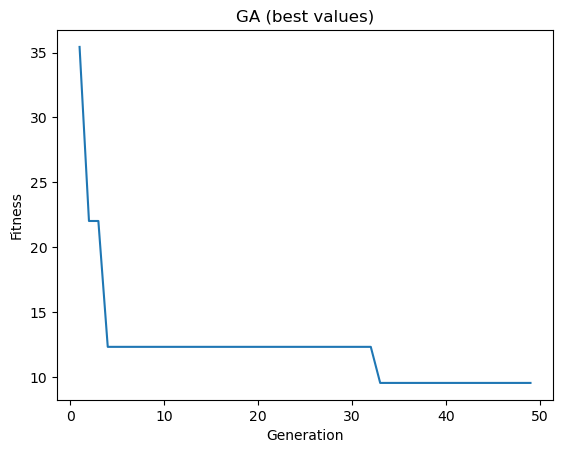

In [70]:
plot_evolution(ga_top_fitness, "GA (best values)")

# PSO
Using a Particle Swarm Optimization approach with the values of X (5 dimensions) as individuals, and trying to minimize the Rastrigin function. 

For this, the following parameters were fixed:
- Population size = 30
- Dimensions = 5
- Generations = 50
- Intertia weights (w) = 0.5
- Acceleration coefficient 1 (c1) = 1
- Acceleration coefficient 2 (c2) = 2


In [42]:
"""
Class for Particle Swarm Optimization
Args:
    pop_size: number of particles in population
    dimensions: number of dimensions for Rastringin problem
    generations: number of max generations to run
    w: intertia weights
    c1: acceleration coefficient 1
    c2: acceleration coefficient 2
""" 
class PSO:
    def __init__(self, pop_size=30, dimensions=5, generations=50, w=0.5, c1=1, c2=2):
        self.dim = dimensions
        self.num_particles = pop_size
        self.max_iter = generations
        self.w = w
        self.c1 = c1
        self.c2 = c2
        
    # Definition of Rastringin Function
    def rastrigin_function(self, x):
        A = 10
        return A * len(x) + sum([(np.power(xi, 2) - A * np.cos(2 * np.pi * xi)) for xi in x])
    
    # Execution of algorithm
    def pso_algorithm(self):
        start_time = time.time()

        particles = np.random.uniform(-5.12, 5.12, (self.num_particles, self.dim))
        velocities = np.zeros((self.num_particles, self.dim))
        top_fitness = []
        
        best_positions = np.copy(particles)
        best_fitness = np.array([self.rastrigin_function(p) for p in particles])
        swarm_best_position = best_positions[np.argmin(best_fitness)]
        swarm_best_fitness = np.min(best_fitness)

        for i in range(self.max_iter):
            top_fitness.append(swarm_best_fitness)
            r1 = np.random.uniform(0, 1, (self.num_particles, self.dim))
            r2 = np.random.uniform(0, 1, (self.num_particles, self.dim))
            velocities = self.w * velocities + self.c1 * r1 * (best_positions - particles) + self.c2 * r2 * (
                        swarm_best_position - particles)
            particles += velocities

            fitness_values = np.array([self.rastrigin_function(p) for p in particles])

            improved_indices = np.where(fitness_values < best_fitness)
            best_positions[improved_indices] = particles[improved_indices]
            best_fitness[improved_indices] = fitness_values[improved_indices]
            if np.min(fitness_values) < swarm_best_fitness:
                swarm_best_position = particles[np.argmin(fitness_values)]
                swarm_best_fitness = np.min(fitness_values)

        return top_fitness, swarm_best_position, swarm_best_fitness, time.time() - start_time


In [43]:
# PSO results
pso = PSO()
pso_top_fitness, pso_best_solution, pso_best_fitness, pso_time = pso.pso_algorithm()
print("Best solution:", pso_best_solution)
print("Best fitness:", pso_best_fitness)

Best solution: [ 0.98379542 -0.02157991  0.02380834 -0.98452134  0.00418975]
Best fitness: 2.136481720353032


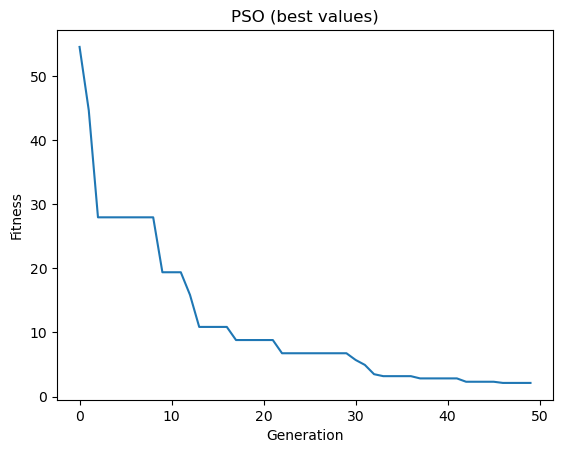

In [71]:
plot_evolution(pso_top_fitness, "PSO (best values)")

# Hybrid approaches
Application of techniques that mix PSO and GA to achieve better results, a few ideas are:
- Use GA to find best set of paremeters for PSO
- Use GA to get best set of individuals for PSO
- Alternate between GA and PSO


### Using GA to find best parameters for PSO
In this approach, the individuals of the Genetic Algorithm are the parameters for PSO (w, c1, c2). The fitness is defined by best result achived with PSO using those sets of parameters.

In [51]:
"""
Class to find best parameters for PSO via GA
"""
class PSO_GA_Parameters(GA):
    def __init__(self, pop_size=30, generations=50, mutation_rate = 0.1):
        self.pop_size = pop_size
        self.dimensions = 3 
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.population = self.initialize_population()
    
    
    # Run the algorithm
    def run_genetic_algorithm(self):
        start_time = time.time()
        best_solution = None
        best_fitness = float('inf')
        top_fitness = []
        
        for _ in range(self.generations):
            fitness_values = []
            for ind in self.population:
                pso = PSO(w=ind[0], c1=ind[1], c2=ind[2])
                pso_top_fitness, pso_best_solution, pso_best_fitness, pso_time = pso.pso_algorithm()
                fitness_values.append(pso_best_fitness)
            fitness_values = np.asarray(fitness_values)
            top_fitness.append(best_fitness)
            
            for i in range(self.pop_size // 2):
                parent1, parent2 = self.tournament_selection(fitness_values)
                child = self.crossover(parent1, parent2)
                child = self.mutation(child)
                self.population[i] = child

            best_idx = np.argmin(fitness_values)
            if fitness_values[best_idx] < best_fitness:
                best_solution = self.population[best_idx]
                best_fitness = fitness_values[best_idx]

        return top_fitness, best_solution, best_fitness, time.time() - start_time 


In [52]:
pso_ga = PSO_GA_Parameters()
pso_ga_top_fitness, pso_ga_best_solution, pso_ga_best_fitness, pso_ga_time = pso_ga.run_genetic_algorithm()
print("Best solution (W, c1, c2):", pso_ga_best_solution)
print("Best fitness:", pso_ga_best_fitness)

Best solution (W, c1, c2): [ 0.79881202 -4.09125245 -2.03680867]
Best fitness: 1.1781031076086421


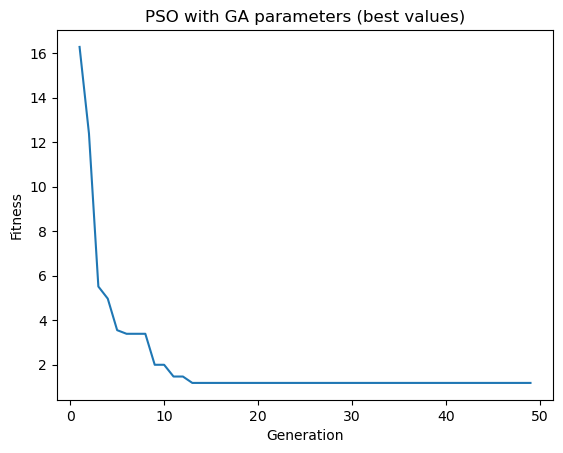

In [72]:
plot_evolution(pso_ga_top_fitness, "PSO with GA parameters (best values)")

## PSO with GA individuals
In this approach, the Genetic Algorithm is used to find the best population, which will be initial population of the Particle Swarm Optimization algorithm. 

In [75]:
"""
Class to find best individuals for PSO via GA
"""
class PSO_GA_Individuals(GA):
    def __init__(self, pop_size, dimensions, generations,mutation_rate = 0.1):
        self.pop_size = pop_size
        self.dimensions = dimensions
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.population = self.initialize_population()
    
    # Run the algorithm
    def run_genetic_algorithm(self):
        start_time = time.time()
        for _ in range(self.generations):
            fitness_values = [self.rastrigin_function(ind) for ind in self.population]

            for i in range(self.pop_size // 2):
                parent1, parent2 = self.tournament_selection(fitness_values)
                child = self.crossover(parent1, parent2)
                child = self.mutation(child)
                self.population[i] = child

        top_fitness, best_solution, best_fitness = self.pso_algorithm(self.population)
        return top_fitness, best_solution, best_fitness, time.time() - start_time
    
       # Execution of algorithm
    def pso_algorithm(self, particles):
        start_time = time.time()
        velocities = np.zeros((self.num_particles, self.dim))
        top_fitness = []
        
        best_positions = np.copy(particles)
        best_fitness = np.array([self.rastrigin_function(p) for p in particles])
        swarm_best_position = best_positions[np.argmin(best_fitness)]
        swarm_best_fitness = np.min(best_fitness)

        for i in range(self.dimensions):
            top_fitness.append(swarm_best_fitness)
            r1 = np.random.uniform(0, 1, (self.num_particles, self.dim))
            r2 = np.random.uniform(0, 1, (self.num_particles, self.dim))
            velocities = self.w * velocities + self.c1 * r1 * (best_positions - particles) + self.c2 * r2 * (
                        swarm_best_position - particles)
            particles += velocities

            fitness_values = np.array([self.rastrigin_function(p) for p in particles])

            improved_indices = np.where(fitness_values < best_fitness)
            best_positions[improved_indices] = particles[improved_indices]
            best_fitness[improved_indices] = fitness_values[improved_indices]
            if np.min(fitness_values) < swarm_best_fitness:
                swarm_best_position = particles[np.argmin(fitness_values)]
                swarm_best_fitness = np.min(fitness_values)

        return top_fitness, swarm_best_position, swarm_best_fitness 


In [76]:
# PSO with GA individuals results
pso_ga_ind = PSO_GA_Individuals(pop_size=100, dimensions=5, generations=50)
pso_ga_ind_top_fitness, pso_ga_ind_best_solution, pso_ga_ind_best_fitness, pso_ga_ind_time = ga.run_genetic_algorithm()
print("Best solution:", pso_ga_ind_best_solution)
print("Best fitness:", pso_ga_ind_best_fitness)

Best solution: [ 1.14850248 -0.91358441  3.99229451  1.40106039  1.84454022]
Best fitness: 4.218518007041922


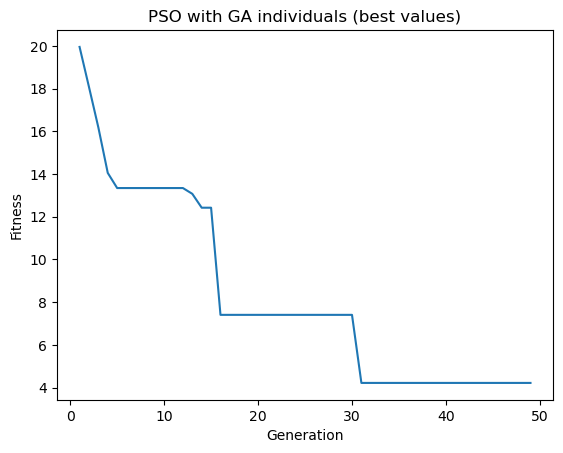

In [77]:
plot_evolution(pso_ga_ind_top_fitness, "PSO with GA individuals (best values)")

## Alternating PSO and GA
In this approach, GA is used to improve the population, which then is used by the PSO. The population results of the PSO is once again used by the GA. This alternation happens for 50 epochs.

In [82]:
"""
Class to alternate between GA and PSO
"""
class PSO_GA_Alternate(GA):
    def __init__(self, pop_size, dimensions, generations,mutation_rate = 0.1):
        self.pop_size = pop_size
        self.dimensions = dimensions
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.population = self.initialize_population()
        self.alternate_epochs = 50
    
    # Run the algorithm
    def run_algorithm(self):
        start_time = time.time()
        top_fitness = []
        for _ in range(self.alternate_epochs):
            self.genetic_algorithm()
            best_solution, best_fitness = self.pso_algorithm()
            top_fitness.append(best_fitness)
        return top_fitness, best_solution, best_fitness, time.time() - start_time
    
    # Execution of genetic algorithm
    def genetic_algorithm(self):
        for _ in range(self.generations):
            fitness_values = [self.rastrigin_function(ind) for ind in self.population]

            for i in range(self.pop_size // 2):
                parent1, parent2 = self.tournament_selection(fitness_values)
                child = self.crossover(parent1, parent2)
                child = self.mutation(child)
                self.population[i] = child
    
    # Execution of algorithm
    def pso_algorithm(self):
        start_time = time.time()
        velocities = np.zeros((self.num_particles, self.dim))
        particles = self.population
        best_positions = np.copy(particles)
        best_fitness = np.array([self.rastrigin_function(p) for p in particles])
        swarm_best_position = best_positions[np.argmin(best_fitness)]
        swarm_best_fitness = np.min(best_fitness)

        for i in range(self.dimensions):
            top_fitness.append(swarm_best_fitness)
            r1 = np.random.uniform(0, 1, (self.num_particles, self.dim))
            r2 = np.random.uniform(0, 1, (self.num_particles, self.dim))
            velocities = self.w * velocities + self.c1 * r1 * (best_positions - particles) + self.c2 * r2 * (
                        swarm_best_position - particles)
            particles += velocities

            fitness_values = np.array([self.rastrigin_function(p) for p in particles])

            improved_indices = np.where(fitness_values < best_fitness)
            best_positions[improved_indices] = particles[improved_indices]
            best_fitness[improved_indices] = fitness_values[improved_indices]
            if np.min(fitness_values) < swarm_best_fitness:
                swarm_best_position = particles[np.argmin(fitness_values)]
                swarm_best_fitness = np.min(fitness_values)
        self.population = particles 
   
        return swarm_best_position, swarm_best_fitness 

In [83]:
# PSO with GA alternating results
pso_ga_alt = PSO_GA_Alternate(pop_size=100, dimensions=5, generations=50)
pso_ga_alt_top_fitness, pso_ga_alt_best_solution, pso_ga_alt_best_fitness, pso_ga_alt_time = ga.run_genetic_algorithm()
print("Best solution:", pso_ga_alt_best_solution)
print("Best fitness:", pso_ga_alt_best_fitness)

Best solution: [ 0.09434369  1.94795311 -2.02467822 -1.80472891  0.97643199]
Best fitness: 8.511158998489506


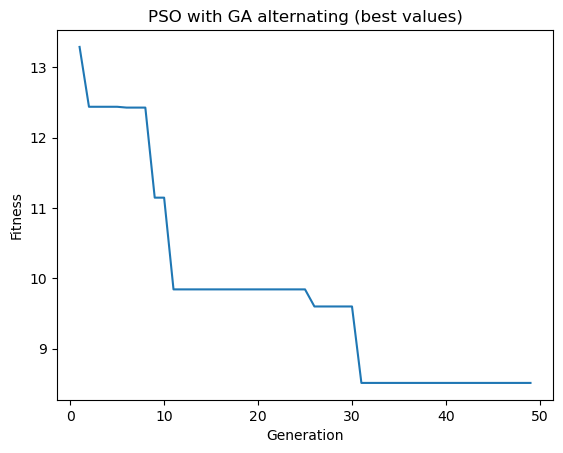

In [85]:
plot_evolution(pso_ga_alt_top_fitness, "PSO with GA alternating (best values)")

# Results

By running all algorithm with a fixed set of 50 epohcs, a few remarks can be made by analyzing the following pictures:
- GA performs the worst of them all.
- PSO has the worst initialization, which is improved by the hybrid approaches, but still had the second best result on the end of the 50 epochs.
- Out of all hybrid implementations, Alternating PSO/GA has the best initialization but doesn't decrease much.
- The best result was achieved by the PSO with GA parameters.
- Timewise, PSO with GA parameters takes the longest time, by a large difference, but still finds the best results in under a minute.
- To facilitate comparisson, the fixed epoch size has to be defined, if instead different approaches used different parameters, the comparisson could have been different ( for example, letting GA run for 1000 epochs, due to the slower converging rate it has.

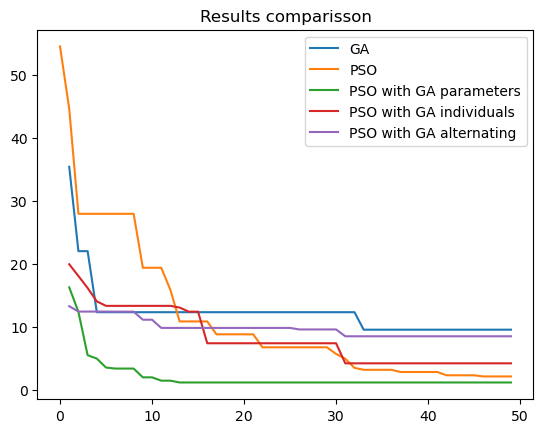

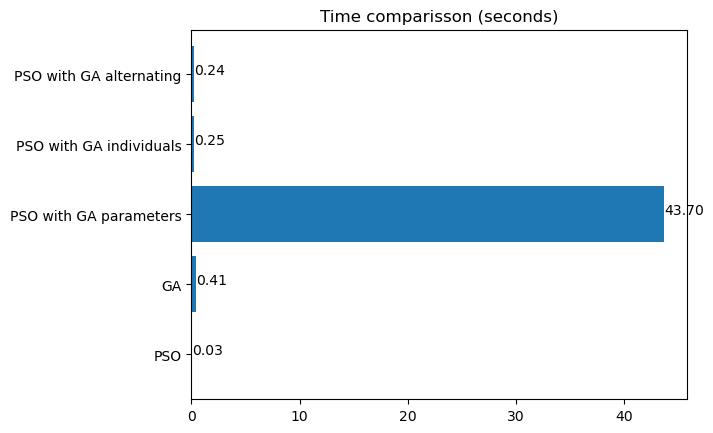

In [86]:
plot_result_comparisson([ga_top_fitness, pso_top_fitness, pso_ga_top_fitness, pso_ga_ind_top_fitness, pso_ga_alt_top_fitness], ["GA","PSO","PSO with GA parameters","PSO with GA individuals","PSO with GA alternating"])
plot_time_comparisson([pso_time, ga_time, pso_ga_time,pso_ga_ind_time, pso_ga_alt_time], ["PSO","GA","PSO with GA parameters", "PSO with GA individuals", "PSO with GA alternating"])

# Optional
- Run GA for longer epochs and use that to compare
- Let PSO run for longer or use larger population size
- 